In [1]:
import h5py
import numpy as np
import os
import pandas as pd
import scipy
import subprocess
import time

from os import listdir
from os.path import isfile, join

import bacco
import baccoemu

import matplotlib
from matplotlib import pyplot as plt

2024-01-09 16:19:21.085749: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2024-01-09 16:19:23.407835: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-01-09 16:19:23.407988: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-01-09 16:19:23.781082: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-01-09 16:19:24.743734: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2024-01-09 16:19:24.749799: I tensorflow/core/platform/cpu_feature_guard.cc:1

In [2]:
matplotlib.rcParams['ytick.labelsize'] = 16
matplotlib.rcParams['xtick.labelsize'] = 16
matplotlib.rcParams['axes.labelsize'] = 18
matplotlib.rcParams['legend.fontsize'] = 14
matplotlib.rcParams['axes.titlesize'] = 20

#matplotlib.rc('text', usetex=True)

## Bacco setup

In [3]:
##### DEFINE QUIJOTE COSMOLOGY ############
# The cosmology is not really needed but
# bacco P(k) corrects some modes according
# to their cosmology, so better have it
# just in case

a_Quijote = 1
Ob = 0.049
Om = 0.3175
hubble = 0.6711
ns = 0.9624
sigma8 = 0.834
cosmopars = dict(
        omega_cdm=Om-Ob,
        omega_baryon=Ob, 
        hubble=hubble, 
        ns=ns, 
        sigma8=sigma8,
        #tau=0.0561,
        A_s=None,
        neutrino_mass=0.,
        w0=-1,
        wa=0,
        tag="cosmo_BOSS"
    )
    
    
cosmo_Quijote = bacco.Cosmology(**cosmopars)
cosmo_Quijote.set_expfactor(a_Quijote)

2024-01-09 16:20:12,617 bacco.cosmo :    initialization took 0.000 secs


In [4]:
ngrid = 256 #1024 #512 #256 #128 #256 #1400
#nmean=0.01 not used
BoxSize=100/hubble
print(BoxSize)

bacco.configuration.update({'pknbody' : {'ngrid'  :  ngrid}})
bacco.configuration.update({'pknbody' : {'log_binning' : True}})
bacco.configuration.update({'pknbody' : {'log_binning_kmax' : 0.99506136}})#
bacco.configuration.update({'pknbody' : {'log_binning_nbins' : 100}})
bacco.configuration.update({'pknbody' : {'min_k' : 0.01721049}})
bacco.configuration.update({'pk' : {'maxk' : 0.99506136}}) 
bacco.configuration.update({'pknbody' : {'interlacing' : True}})

bacco.configuration.update({'pknbody' : {'depmethod' : 'cic'}})

bacco.configuration.update({'nonlinear' : {'concentration' : 'ludlow16'}})

bacco.configuration.update({'number_of_threads' : 12})
bacco.configuration.update({'scaling' : {'disp_ngrid' : ngrid}})

bacco.configuration.update({'pk':{'boltzmann_solver': 'CLASS'}})

149.0090895544628


## Load SAM data from hdf5 files

In [5]:
redshift = 0
dir_dat = '/lscratch/kstoreyf/CAMELS-SAM_data'

In [6]:
#fns_dat = [join(dir_dat, f) for f in listdir(dir_dat) if isfile(join(dir_dat, f))]
idxs_sam = [idx_sam for idx_sam in np.arange(0, 50) if isfile(f'{dir_dat}/LH_{idx_sam}_galprops_z{redshift}.hdf5')]
# get first N for this notebook
idxs_sam = idxs_sam[:30]
n_sams = len(idxs_sam)
fns_dat = [f'{dir_dat}/LH_{idx_sam}_galprops_z{redshift}.hdf5' for idx_sam in idxs_sam]

In [7]:
n_sams = len(fns_dat)

## Load PROVABGS data

Downloaded from https://zenodo.org/records/8018936

In [8]:
# probabilistic SMFs
fn_psmf_bgs_q = '../data/data_provabgs/psmf.sv3.bgs_bright_q.z0.01_0.05.dat'
ms, psmf_bgs_q_mean, psmf_bgs_q_std = np.loadtxt(fn_psmf_bgs_q, unpack=True)

fn_psmf_bgs_sf = '../data/data_provabgs/psmf.sv3.bgs_bright_sf.z0.01_0.05.dat'
ms, psmf_bgs_sf_mean, psmf_bgs_sf_std = np.loadtxt(fn_psmf_bgs_sf, unpack=True)

In [9]:
# combine sf and q (star-forming and quiescent)
psmf_bgs_mean = psmf_bgs_sf_mean + psmf_bgs_q_mean
psmf_bgs_std = np.sqrt(psmf_bgs_sf_std**2 + psmf_bgs_q_std**2)

In [10]:
# standard (non-probabilistic) SMF, as check
fn_smf_bgs = '../data/data_provabgs/smf.standard.sv3.bgs_bright.z0.01_0.05.dat'
ms_smf, smf_bgs = np.loadtxt(fn_smf_bgs, unpack=True)

## Plot CAMELS SMFs

In [11]:
log_mass_shift = 9
h = 0.6711 # from perez et al
print(h**3)
vol_Mpc = (100/h)**3 # 100 Mpc/h = 100/h Mpc
vol_hMpc = 100**3 # units Mpc/h!! to match bgs; diff than plotted in camels paper
print(vol_Mpc, vol_hMpc)

0.302246803431
3308554.428527777 1000000


In [12]:
edges = np.linspace(8, 12.5, 40)

bin_width = edges[1] - edges[0]                
bins_avg = edges[0:-1] + bin_width/2.           

In [13]:
smf_arr = []
nbar_arr = []
for i in range(n_sams):
    fn_dat = fns_dat[i]
    with h5py.File(fn_dat, 'r') as f:
        mstar_raw = np.array(f['mstar'])
        log_mstar = np.log10(mstar_raw) + log_mass_shift
        
        phi, edges = np.histogram(log_mstar, bins=edges)   
        smf = phi / vol_Mpc / bin_width
        smf_arr.append(smf)    
        
        nbar_arr.append(len(mstar_raw)/vol_Mpc)

/tmp/ipykernel_227682/292810891.py:7: RuntimeWarning: divide by zero encountered in log10
  log_mstar = np.log10(mstar_raw) + log_mass_shift


In [14]:
def get_distance_sigma(x1, y1, yerr1, x2, y2, xrange):
    xmin, xmax = xrange

    y1 = y1[(x1>=xmin) & (x1<xmax)]
    yerr1 = yerr1[(x1>=xmin) & (x1<xmax)]
    y2 = y2[(x2>=xmin) & (x2<xmax)]

    x1 = x1[(x1>=xmin) & (x1<xmax)]
    x2 = x2[(x2>=xmin) & (x2<xmax)]
    
    # interpolate y2 to be at the same x-vals as x2/y2
    y2_interp = np.interp(x1, x2, y2)
    sigmas = (y2_interp - y1)/yerr1
    sigma_mean = np.mean(np.abs(sigmas))
    return sigma_mean

In [15]:
sigma_means = []
xrange = [8,11]
for i in range(n_sams):
    
    sigma_mean = get_distance_sigma(ms, psmf_bgs_mean, psmf_bgs_std, bins_avg, smf_arr[i], xrange)
    sigma_means.append(sigma_mean)
sigma_means = np.array(sigma_means)

In [16]:
locs_norm = matplotlib.colors.Normalize(np.min(sigma_means), np.max(sigma_means), len(sigma_means))
cmap = matplotlib.cm.get_cmap('cool_r')
colors = cmap(locs_norm(sigma_means))

/tmp/ipykernel_227682/431812615.py:2: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = matplotlib.cm.get_cmap('cool_r')


(8.0, 12.5)

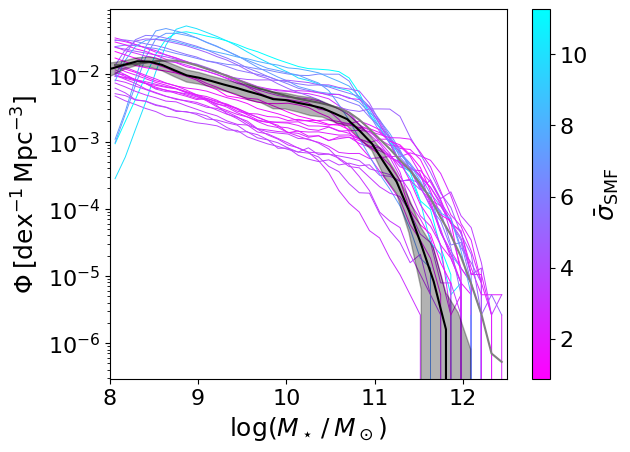

In [17]:
for i in range(n_sams):
    plt.plot(bins_avg, smf_arr[i], lw=0.7, color=colors[i])
ax = plt.gca()
sm = plt.cm.ScalarMappable(cmap=cmap, norm=locs_norm)
plt.colorbar(sm, ax=ax, label=r'$\bar{\sigma}_\text{SMF}$')

smf_mean = np.mean(smf_arr, axis=0)
smf_std = np.std(smf_arr, axis=0)
plt.plot(bins_avg, smf_mean, color='grey')
# plt.fill_between(bins_avg, 
#                  (smf_mean-smf_std), 
#                  (smf_mean+smf_std),
#                  color='magenta', alpha=0.3, lw=2,
#                  label='pSMF all')
    
plt.plot(ms, psmf_bgs_mean, color='black')
plt.fill_between(ms, 
                 psmf_bgs_mean-psmf_bgs_std, 
                 psmf_bgs_mean+psmf_bgs_std,
                 color='black', alpha=0.3,
                 zorder=10000,
                 label='BGS pSMF')
    
plt.yscale('log')
plt.xlabel(r'$\log(M_\star\,/\,M_\odot)$')
plt.ylabel(r'$\Phi \: [\mathrm{dex}^{-1}\, \mathrm{Mpc}^{-3}]$')
plt.xlim(8, 12.5)

## Set up bacco P(k) code

In [18]:
args_power = {'ngrid':ngrid,
                  'box':BoxSize,
                  'cosmology':cosmo_Quijote,
                  'interlacing':True,
                  'kmin':0.01,
                  'kmax':1.0,
                  'nbins':16,
                  'correct_grid':True,
                  'log_binning':False,
                  'deposit_method':'cic',
                  'compute_correlation':False,
                  'zspace':False,
                  'normalise_grid': True,
                  'compute_power2d':False}

In [19]:
import logging
logger = logging.getLogger("bacco.power")
# only log really bad events
logger.setLevel(logging.ERROR)

In [20]:
pks = []
for i in range(n_sams):
    fn_dat = fns_dat[i]
    with h5py.File(fn_dat, 'r') as f:
        x_arr, y_arr, z_arr = f['x_position'], f['y_position'], f['z_position']
        pos_arr = np.array([x_arr, y_arr, z_arr]).T
        pk = bacco.statistics.compute_powerspectrum(pos=pos_arr, **args_power)
        pks.append(pk)

2024-01-09 16:20:14,172 bacco.statistics : Computing the power spectrum with ngrid=256 and interlacing=True
2024-01-09 16:20:14,838 bacco.cosmo :    computed CAMB power spectrum at z=0.00 in 0.234 secs
2024-01-09 16:20:14,841 bacco.cosmo :    created Pk(z=0) tab from k 7.450454722857103e-05 to 100000.0 h/Mpc
2024-01-09 16:20:14,918 bacco.cosmo :    computed halofit at z=0.00 for 'cosmo_BOSS' in 0.002 secs
2024-01-09 16:20:14,919 bacco.statistics :  setting the grid 256 True
2024-01-09 16:20:14,920 bacco.statistics : Computing cic mesh with ngrid=256 and interlacing=True
2024-01-09 16:20:14,922 bacco.statistics : starting deposit 1
2024-01-09 16:20:15,029 bacco.statistics :  mesh done in 0.109 s
2024-01-09 16:20:15,030 bacco.statistics :  Starting the power spectrum calculation
2024-01-09 16:20:15,267 bacco.statistics :  done compute.power
2024-01-09 16:20:15,268 bacco.statistics :  power done in 1.1 s
2024-01-09 16:20:15,297 bacco.statistics : Computing the power spectrum with ngrid=25

bacco.mesh : boxsize=149.009094 ngrid=256, nthreads=12, vel_factor=0.000000, interlacing=1, folds=1.000000, 2d=0
bacco.mesh : allocating 128.0 Mb
bacco.mesh : binning of 174733 particles (1 with mass)
bacco.mesh : Using mass = 1.000000
bacco.power : boxsize 149.009094; ngrid 256; nthreads 12; interlacing 1; deposit_method 1; log_binning 0; type 0; precision=single; correct_grid=1 (log=1); correct_sn=0
bacco.power : normalise_grid1=1 normalise_grid2=1 deconvolve_grid1=1 deconvolve_grid2=1
bacco.power : total mass 174733 (grid1) 174733 (grid2)
bacco.power : Doing FFTW
bacco.power: FFT took 0.062587 sec
bacco.power : Counting modes
bacco.power : done counting modes in 0.092196 sec
bacco.power : Starting Fourier loop 
bacco.power : done Fourier loop in 0.000154 secs
bacco.power : Deallocating arrays
bacco.mesh : boxsize=149.009094 ngrid=256, nthreads=12, vel_factor=0.000000, interlacing=1, folds=1.000000, 2d=0
bacco.mesh : allocating 128.0 Mb
bacco.mesh : binning of 135120 particles (1 wit

2024-01-09 16:20:17,048 bacco.statistics :  done compute.power
2024-01-09 16:20:17,050 bacco.statistics :  power done in 0.322 s
2024-01-09 16:20:17,100 bacco.statistics : Computing the power spectrum with ngrid=256 and interlacing=True
2024-01-09 16:20:17,101 bacco.statistics :  setting the grid 256 True
2024-01-09 16:20:17,101 bacco.statistics : Computing cic mesh with ngrid=256 and interlacing=True
2024-01-09 16:20:17,102 bacco.statistics : starting deposit 1
2024-01-09 16:20:17,174 bacco.statistics :  mesh done in 0.0728 s
2024-01-09 16:20:17,182 bacco.statistics :  Starting the power spectrum calculation
2024-01-09 16:20:17,379 bacco.statistics :  done compute.power
2024-01-09 16:20:17,380 bacco.statistics :  power done in 0.28 s
2024-01-09 16:20:17,411 bacco.statistics : Computing the power spectrum with ngrid=256 and interlacing=True
2024-01-09 16:20:17,414 bacco.statistics :  setting the grid 256 True
2024-01-09 16:20:17,415 bacco.statistics : Computing cic mesh with ngrid=256 

actor=0.000000, interlacing=1, folds=1.000000, 2d=0
bacco.mesh : allocating 128.0 Mb
bacco.mesh : binning of 176420 particles (1 with mass)
bacco.mesh : Using mass = 1.000000
bacco.power : boxsize 149.009094; ngrid 256; nthreads 12; interlacing 1; deposit_method 1; log_binning 0; type 0; precision=single; correct_grid=1 (log=1); correct_sn=0
bacco.power : normalise_grid1=1 normalise_grid2=1 deconvolve_grid1=1 deconvolve_grid2=1
bacco.power : total mass 176420 (grid1) 176420 (grid2)
bacco.power : Doing FFTW
bacco.power: FFT took 0.069218 sec
bacco.power : Counting modes
bacco.power : done counting modes in 0.102593 sec
bacco.power : Starting Fourier loop 
bacco.power : done Fourier loop in 0.000117 secs
bacco.power : Deallocating arrays
bacco.mesh : boxsize=149.009094 ngrid=256, nthreads=12, vel_factor=0.000000, interlacing=1, folds=1.000000, 2d=0
bacco.mesh : allocating 128.0 Mb
bacco.mesh : binning of 151754 particles (1 with mass)
bacco.mesh : Using mass = 1.000000
bacco.power : boxs

2024-01-09 16:20:19,037 bacco.statistics :  done compute.power
2024-01-09 16:20:19,038 bacco.statistics :  power done in 0.43 s
2024-01-09 16:20:19,069 bacco.statistics : Computing the power spectrum with ngrid=256 and interlacing=True
2024-01-09 16:20:19,091 bacco.statistics :  setting the grid 256 True
2024-01-09 16:20:19,092 bacco.statistics : Computing cic mesh with ngrid=256 and interlacing=True
2024-01-09 16:20:19,094 bacco.statistics : starting deposit 1
2024-01-09 16:20:19,175 bacco.statistics :  mesh done in 0.0823 s
2024-01-09 16:20:19,176 bacco.statistics :  Starting the power spectrum calculation
2024-01-09 16:20:19,432 bacco.statistics :  done compute.power
2024-01-09 16:20:19,433 bacco.statistics :  power done in 0.365 s
2024-01-09 16:20:19,462 bacco.statistics : Computing the power spectrum with ngrid=256 and interlacing=True
2024-01-09 16:20:19,464 bacco.statistics :  setting the grid 256 True
2024-01-09 16:20:19,466 bacco.statistics : Computing cic mesh with ngrid=256 

h : allocating 128.0 Mb
bacco.mesh : binning of 154917 particles (1 with mass)
bacco.mesh : Using mass = 1.000000
bacco.power : boxsize 149.009094; ngrid 256; nthreads 12; interlacing 1; deposit_method 1; log_binning 0; type 0; precision=single; correct_grid=1 (log=1); correct_sn=0
bacco.power : normalise_grid1=1 normalise_grid2=1 deconvolve_grid1=1 deconvolve_grid2=1
bacco.power : total mass 154917 (grid1) 154917 (grid2)
bacco.power : Doing FFTW
bacco.power: FFT took 0.116130 sec
bacco.power : Counting modes
bacco.power : done counting modes in 0.101905 sec
bacco.power : Starting Fourier loop 
bacco.power : done Fourier loop in 0.000110 secs
bacco.power : Deallocating arrays
bacco.mesh : boxsize=149.009094 ngrid=256, nthreads=12, vel_factor=0.000000, interlacing=1, folds=1.000000, 2d=0
bacco.mesh : allocating 128.0 Mb
bacco.mesh : binning of 166849 particles (1 with mass)
bacco.mesh : Using mass = 1.000000
bacco.power : boxsize 149.009094; ngrid 256; nthreads 12; interlacing 1; deposi

2024-01-09 16:20:21,000 bacco.statistics :  done compute.power
2024-01-09 16:20:21,002 bacco.statistics :  power done in 0.337 s
2024-01-09 16:20:21,031 bacco.statistics : Computing the power spectrum with ngrid=256 and interlacing=True
2024-01-09 16:20:21,033 bacco.statistics :  setting the grid 256 True
2024-01-09 16:20:21,034 bacco.statistics : Computing cic mesh with ngrid=256 and interlacing=True
2024-01-09 16:20:21,035 bacco.statistics : starting deposit 1
2024-01-09 16:20:21,116 bacco.statistics :  mesh done in 0.0826 s
2024-01-09 16:20:21,125 bacco.statistics :  Starting the power spectrum calculation
2024-01-09 16:20:21,408 bacco.statistics :  done compute.power
2024-01-09 16:20:21,409 bacco.statistics :  power done in 0.378 s
2024-01-09 16:20:21,464 bacco.statistics : Computing the power spectrum with ngrid=256 and interlacing=True
2024-01-09 16:20:21,465 bacco.statistics :  setting the grid 256 True
2024-01-09 16:20:21,466 bacco.statistics : Computing cic mesh with ngrid=256

les (1 with mass)
bacco.mesh : Using mass = 1.000000
bacco.power : boxsize 149.009094; ngrid 256; nthreads 12; interlacing 1; deposit_method 1; log_binning 0; type 0; precision=single; correct_grid=1 (log=1); correct_sn=0
bacco.power : normalise_grid1=1 normalise_grid2=1 deconvolve_grid1=1 deconvolve_grid2=1
bacco.power : total mass 152059 (grid1) 152059 (grid2)
bacco.power : Doing FFTW
bacco.power: FFT took 0.058485 sec
bacco.power : Counting modes
bacco.power : done counting modes in 0.094590 sec
bacco.power : Starting Fourier loop 
bacco.power : done Fourier loop in 0.000094 secs
bacco.power : Deallocating arrays
bacco.mesh : boxsize=149.009094 ngrid=256, nthreads=12, vel_factor=0.000000, interlacing=1, folds=1.000000, 2d=0
bacco.mesh : allocating 128.0 Mb
bacco.mesh : binning of 164702 particles (1 with mass)
bacco.mesh : Using mass = 1.000000
bacco.power : boxsize 149.009094; ngrid 256; nthreads 12; interlacing 1; deposit_method 1; log_binning 0; type 0; precision=single; correct_

2024-01-09 16:20:23,042 bacco.statistics :  mesh done in 0.0801 s
2024-01-09 16:20:23,043 bacco.statistics :  Starting the power spectrum calculation
2024-01-09 16:20:23,252 bacco.statistics :  done compute.power
2024-01-09 16:20:23,253 bacco.statistics :  power done in 0.294 s
2024-01-09 16:20:23,283 bacco.statistics : Computing the power spectrum with ngrid=256 and interlacing=True
2024-01-09 16:20:23,284 bacco.statistics :  setting the grid 256 True
2024-01-09 16:20:23,285 bacco.statistics : Computing cic mesh with ngrid=256 and interlacing=True
2024-01-09 16:20:23,286 bacco.statistics : starting deposit 1
2024-01-09 16:20:23,377 bacco.statistics :  mesh done in 0.0924 s
2024-01-09 16:20:23,378 bacco.statistics :  Starting the power spectrum calculation
2024-01-09 16:20:23,622 bacco.statistics :  done compute.power
2024-01-09 16:20:23,623 bacco.statistics :  power done in 0.34 s
2024-01-09 16:20:23,650 bacco.statistics : Computing the power spectrum with ngrid=256 and interlacing=Tr

wer : boxsize 149.009094; ngrid 256; nthreads 12; interlacing 1; deposit_method 1; log_binning 0; type 0; precision=single; correct_grid=1 (log=1); correct_sn=0
bacco.power : normalise_grid1=1 normalise_grid2=1 deconvolve_grid1=1 deconvolve_grid2=1
bacco.power : total mass 172757 (grid1) 172757 (grid2)
bacco.power : Doing FFTW
bacco.power: FFT took 0.065497 sec
bacco.power : Counting modes
bacco.power : done counting modes in 0.093322 sec
bacco.power : Starting Fourier loop 
bacco.power : done Fourier loop in 0.000175 secs
bacco.power : Deallocating arrays
bacco.mesh : boxsize=149.009094 ngrid=256, nthreads=12, vel_factor=0.000000, interlacing=1, folds=1.000000, 2d=0
bacco.mesh : allocating 128.0 Mb
bacco.mesh : binning of 170257 particles (1 with mass)
bacco.mesh : Using mass = 1.000000
bacco.power : boxsize 149.009094; ngrid 256; nthreads 12; interlacing 1; deposit_method 1; log_binning 0; type 0; precision=single; correct_grid=1 (log=1); correct_sn=0
bacco.power : normalise_grid1=1 

2024-01-09 16:20:25,073 bacco.statistics :  mesh done in 0.0807 s
2024-01-09 16:20:25,073 bacco.statistics :  Starting the power spectrum calculation
2024-01-09 16:20:25,337 bacco.statistics :  done compute.power
2024-01-09 16:20:25,338 bacco.statistics :  power done in 0.349 s
2024-01-09 16:20:25,374 bacco.statistics : Computing the power spectrum with ngrid=256 and interlacing=True
2024-01-09 16:20:25,376 bacco.statistics :  setting the grid 256 True
2024-01-09 16:20:25,376 bacco.statistics : Computing cic mesh with ngrid=256 and interlacing=True
2024-01-09 16:20:25,377 bacco.statistics : starting deposit 1
2024-01-09 16:20:25,456 bacco.statistics :  mesh done in 0.0797 s
2024-01-09 16:20:25,466 bacco.statistics :  Starting the power spectrum calculation
2024-01-09 16:20:25,795 bacco.statistics :  done compute.power
2024-01-09 16:20:25,796 bacco.statistics :  power done in 0.421 s
2024-01-09 16:20:25,852 bacco.statistics : Computing the power spectrum with ngrid=256 and interlacing=T

Text(0, 0.5, '$P(k)$')

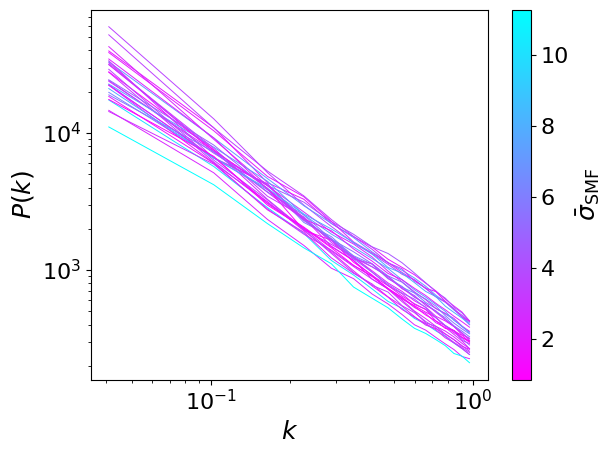

In [21]:
for i in range(n_sams):
    plt.plot(pks[i]['k'], pks[i]['pk'], lw=0.7, color=colors[i])
    
ax = plt.gca()
sm = plt.cm.ScalarMappable(cmap=cmap, norm=locs_norm)
plt.colorbar(sm, ax=ax, label=r'$\bar{\sigma}_\text{SMF}$')
    
plt.xscale('log')
plt.yscale('log')
plt.xlabel(r'$k$')
plt.ylabel(r'$P(k)$')

In [22]:
k_sam_all = pks[0]['k'] # same for all 

## Load bacco emu

In [23]:
emulator = baccoemu.Lbias_expansion()

Loading l-bias lpt emulator...


/dipc/kstoreyf/.conda/envs/baccoenv/lib/python3.11/site-packages/sklearn/base.py:348: InconsistentVersionWarning: Trying to unpickle estimator PCA from version 0.24.2 when using version 1.3.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/dipc/kstoreyf/.conda/envs/baccoenv/lib/python3.11/site-packages/sklearn/base.py:348: InconsistentVersionWarning: Trying to unpickle estimator StandardScaler from version 0.24.2 when using version 1.3.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/dipc/kstoreyf/.conda/envs/baccoenv/lib/python3.11/site-packages/sklearn/base.py:348: InconsistentVersionWarning: Trying to unpickle estimator PCA from version 0.24.2 when u

/dipc/kstoreyf/.conda/envs/baccoenv/lib/python3.11/site-packages/sklearn/base.py:348: InconsistentVersionWarning: Trying to unpickle estimator PCA from version 0.24.2 when using version 1.3.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/dipc/kstoreyf/.conda/envs/baccoenv/lib/python3.11/site-packages/sklearn/base.py:348: InconsistentVersionWarning: Trying to unpickle estimator StandardScaler from version 0.24.2 when using version 1.3.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/dipc/kstoreyf/.conda/envs/baccoenv/lib/python3.11/site-packages/sklearn/base.py:348: InconsistentVersionWarning: Trying to unpickle estimator PCA from version 0.24.2 when u

L-bias lpt emulator loaded in memory.
Loading smeared bao emulator...


/dipc/kstoreyf/.conda/envs/baccoenv/lib/python3.11/site-packages/sklearn/base.py:348: InconsistentVersionWarning: Trying to unpickle estimator PCA from version 1.0 when using version 1.3.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/dipc/kstoreyf/.conda/envs/baccoenv/lib/python3.11/site-packages/sklearn/base.py:348: InconsistentVersionWarning: Trying to unpickle estimator StandardScaler from version 1.0 when using version 1.3.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


Smeared bao emulator loaded in memory.
Loading non-linear l-bias emulator...


/dipc/kstoreyf/.conda/envs/baccoenv/lib/python3.11/site-packages/sklearn/base.py:348: InconsistentVersionWarning: Trying to unpickle estimator StandardScaler from version 0.23.2 when using version 1.3.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/dipc/kstoreyf/.conda/envs/baccoenv/lib/python3.11/site-packages/sklearn/base.py:348: InconsistentVersionWarning: Trying to unpickle estimator PCA from version 0.23.2 when using version 1.3.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


Nonlinear l-bias emulator loaded in memory.
Loading sigma8 emulator...
Sigma8 emulator loaded in memory.
Loading no-wiggles emulator...
No-wiggles emulator loaded in memory.


/dipc/kstoreyf/.conda/envs/baccoenv/lib/python3.11/site-packages/sklearn/base.py:348: InconsistentVersionWarning: Trying to unpickle estimator StandardScaler from version 1.0.2 when using version 1.3.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


In [24]:
#k = np.logspace(-1.9, np.log10(emulator.emulator['nonlinear']['k'].max()), num=100)

In [25]:
# should this match camels??
cosmo_params = {
    'omega_cold'    :  Om,
    'sigma8_cold'   :  sigma8, # if A_s is not specified
    'omega_baryon'  :  Ob,
    'ns'            :  ns,
    'hubble'        :  hubble,
    'neutrino_mass' :  0.0,
    'w0'            : -1.0,
    'wa'            :  0.0,
    'expfactor'     :  1
}

In [26]:
#k, pnn = emulator.get_nonlinear_pnn(k=k, **params)

### Fit bias params

In [27]:
def ln_like(free_params, k_data, pk_data, variance,
            nbar, emulator, cosmo_params):
    bias_params = free_params[:4]
    A_sn = free_params[-1]
    _, pk_gg, _ = emulator.get_galaxy_real_pk(bias=bias_params, k=k_data,
                                             **cosmo_params)
    pk_model = pk_gg + A_sn/nbar
    delta_y = pk_data - pk_gg
    lnlk = 0.5 * np.sum((delta_y/variance)**2)
    #lnlk = 0.5 * delta_y.T @ C_inv @ delta_y
    return lnlk

In [28]:
i_bins = k_sam_all < 0.75
k_sam = k_sam_all[i_bins]
C_inv = np.diag(np.ones(len(k_sam))/len(k_sam))

In [29]:
bias_param_names = ['b1', 'b2', 'bs2', 'bl']
bias_param_labels = {'b1': r'$b_1$', 
                     'b2': r'$b_2$', 
                     'bs2': r'$b_{s^2}$', 
                     'bl': r'$b_{\nabla^2 \delta}$',
                    }
free_param_names = bias_param_names + ['Asn']
bounds_dict = {'b1': [-5, 20],
                'b2': [-5, 10],
                'bs2': [-10, 20],
                'bl': [-20, 30],
                'Asn': [0, 2],
                }
bounds = [bounds_dict[param_name] for param_name in free_param_names]

In [30]:
n_fit = 1

In [31]:
free_params_0 = [0.5, 0.5, 1.0, -1.0, 1.0]
res_arr = []
var_arr = []
for i in range(n_fit):
    print(f"Fitting SAM {i}")
    pk_sam = pks[i]['pk'][i_bins]
    
    err_poisson = pk['shotnoise'][i_bins]
    err_1p = 0.01*pk_sam
    variance = err_poisson**2 + err_1p**2
    var_arr.append(variance)

    res = scipy.optimize.minimize(ln_like, free_params_0, bounds=bounds, 
                                  args=(k_sam, pk_sam, variance, nbar_arr[i], emulator, cosmo_params))
    res_arr.append(res)

Fitting SAM 0


In [32]:
print(np.sum([res['success'] for res in res_arr]))

1


Text(0.5, 0, '$k$')

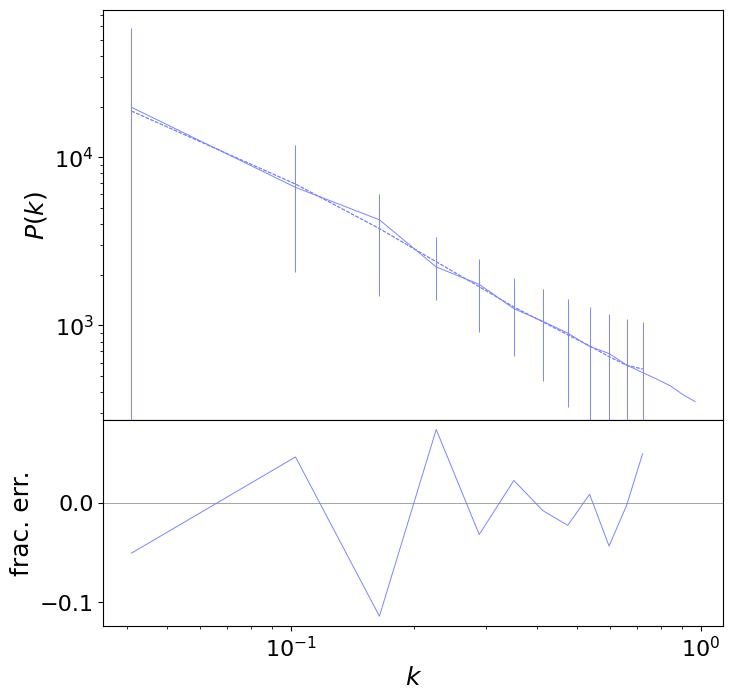

In [34]:
nrows, ncols = 2, 1
fig, axarr = plt.subplots(nrows, ncols, figsize=(8,8), sharex=True, height_ratios=[2,1])
plt.subplots_adjust(hspace=0)

for i in range(n_fit):
    axarr[0].plot(pks[i]['k'], pks[i]['pk'], lw=0.7, color=colors[i])
    bias_params = res_arr[i]['x'][:4]
    _, pk_emu, _ = emulator.get_galaxy_real_pk(bias=bias_params, k=k_sam, **cosmo_params)
    axarr[0].plot(k_sam, pk_emu, lw=0.7, ls='--', color=colors[i])
    axarr[0].errorbar(k_sam, pk_emu, yerr=var_arr[i], lw=0.7, ls='--', color=colors[i])
    axarr[0].set_ylabel(r'$P(k)$')
    
    axarr[1].plot(k_sam, (pk_emu-pks[i]['pk'][i_bins])/pks[i]['pk'][i_bins], lw=0.7, color=colors[i])
    axarr[1].set_ylabel('frac. err.')
    axarr[1].axhline(0, color='grey', lw=0.5)

plt.xscale('log')
axarr[0].set_yscale('log')
plt.xlabel(r'$k$')

## Plot bias params

In [ ]:
nrows, ncols = 3, 1
fig, axarr = plt.subplots(nrows, ncols, figsize=(5, 3*nrows), sharex=True)
plt.subplots_adjust(hspace=0)

for i in range(n_fit):
    bias_params = res_arr[i]['x']
    for bb in range(1,len(bias_param_names)):
        axarr[bb-1].plot(bias_params[0], bias_params[bb], marker='o', markersize=6, color=colors[i])
        axarr[bb-1].set_ylabel(bias_param_labels[bias_param_names[bb]])

plt.xlabel(bias_param_labels[bias_param_names[0]])